In [2]:
# Python 3.9. Anaconda recommended.
# -- Prerequisites install 
%pip install ipykernel --user
%pip install stable_baselines3 --user
%pip install tensorboard --user
%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


^C


# STABLEBASELINES TESTBED

In [18]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, nr_batteries, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1
      
      
      self.nr_batteries = nr_batteries


      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.nr_batteries,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.nr_batteries,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."


      battery_current_values = get_converted_action(action)


      self.episode_time += 1
      passed_threshold = False
      terminated = False
      truncated = False

      oldSocs = self.state 

      #Apply action to state
      self.state = np.subtract(self.state, battery_current_values)         

      for soc in self.state:

         if (soc < self.soc_threshold_lower or soc > self.soc_threshold_upper):
            passed_threshold = True
         if (soc < 0 or soc > 100):
            # Sanity check. Should never happen.
            soc = 0.0
            print("//////// EXITED OBSERVATION SPACE BOUNDS ////////  "  + str(soc))



      # Compute reward and termination cases
      reward = 0
      if not passed_threshold and self.episode_time == 128:
         # Apply step reward. Timeout.
         reward = compute_ballancing_reward(oldSocs, self.state, False)

         self.episode_time = 0
         truncated = True

      elif not passed_threshold:
         # Apply step reward. Continue running.
         reward = compute_ballancing_reward(oldSocs, self.state, False)

      
      elif passed_threshold:
         # Batteries drained! Terminated.
         reward = float(-100)
         terminated = True


      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}
   

       


   def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,):
        
         super().reset(seed=seed)



         self.episode_time = 0


         # Get random initial state for the episode.
         self.state = self.np_random.uniform(low=0.50, high=0.85, size=(self.nr_batteries,))


         return np.array(self.state, dtype=np.float32), {}



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0) * 5.0)/100.0  #from [-1, 1] to [0, 0.1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff_from_mean), or (mean_diff_from_mean*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.6, 0.5, 0.8, 0.65, 0.85]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation






# Get reward for a given step
def compute_ballancing_reward(pre_action_socs, post_action_socs, should_print):

   # ---- REWARD ALTERNATIVES ----

   # 1. Cost as distance between 2 numbers. Yang
   #reward = -pow(soc0 - soc1, 2)
      
   # 2. Cost as standard deviation
   # reward = -np.std(normalized_socs, dtype=np.float32)

   # ---- REWARD ALTERNATIVES ----


   

   reward = 0

   # Give 0.2 for each pair of SOCs that are within 0.02 distance of eachother.
   for i in range(len(post_action_socs)):
      for j in range(i + 1, len(post_action_socs)):
         if (math.isclose(post_action_socs[i], post_action_socs[j], abs_tol=0.02)):
            reward += 0.2

   # reward = reward / 50
   
   # Introduce closeness to the reward
   # reward = reward - compute_closeness(post_action_socs)


   # apply penalty for discharging the smallest soc battery
   if min(pre_action_socs) != min(post_action_socs):
      reward -= 10

   
   # apply penalty for total amount of discharge in the pack
   changes = np.subtract(pre_action_socs, post_action_socs)
   reward -= sum(changes)     



             
   return reward




0.35
0.12884098


# PLOTTING FUNCTIONS:

In [19]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [20]:
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import os
import torch
import math
import numpy as np
from typing import Optional, Union




class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(self.log_dir)

        return True
    
    



# Initialize environment

In [21]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env


# Create log dir
log_dir = "./tmp/gym/td3test-50/"
os.makedirs(log_dir, exist_ok=True)


# Create and wrap the environment
env = BatteryEnv(50, False)

for i in range(0, 100):
    check_env(env)


# Logs will be saved in log_dir/monitor.csv 
env = Monitor(env, log_dir) #monitor for raw environments



# Opt1: Initialize a new model

In [22]:
from stable_baselines3 import A2C, SAC, PPO, TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


print("Is CUDA enabled?", torch.cuda.is_available())


n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = SAC('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./td3-50_tensorboard_log/")



Is CUDA enabled? True


# Opt 2: Load existing trained model from save file

In [15]:
from stable_baselines3 import A2C, SAC, PPO, TD3

model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3"))

Train model for X timesteps.
Can be interrupted and retain training.

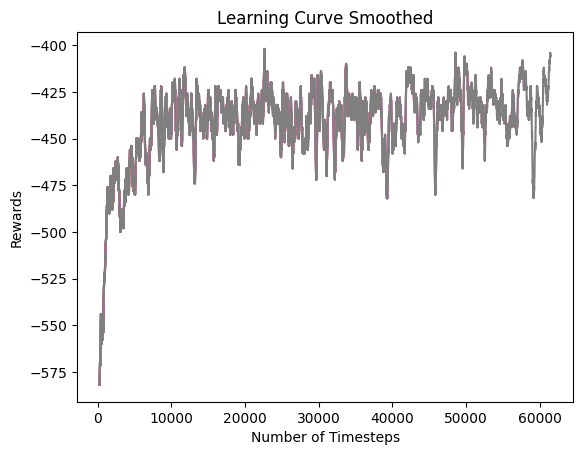

Eval num_timesteps=60800, episode_reward=-416.00 +/- 36.66
Episode length: 4.16 +/- 0.37
Eval num_timesteps=64000, episode_reward=-458.00 +/- 49.36
Episode length: 4.58 +/- 0.49
Eval num_timesteps=67200, episode_reward=-414.00 +/- 34.70
Episode length: 4.14 +/- 0.35
Eval num_timesteps=70400, episode_reward=-432.00 +/- 46.65
Episode length: 4.32 +/- 0.47
Eval num_timesteps=73600, episode_reward=-418.00 +/- 38.42
Episode length: 4.18 +/- 0.38
Eval num_timesteps=76800, episode_reward=-438.00 +/- 48.54
Episode length: 4.38 +/- 0.49
Eval num_timesteps=80000, episode_reward=-436.00 +/- 48.00
Episode length: 4.36 +/- 0.48
Eval num_timesteps=83200, episode_reward=-406.00 +/- 23.75
Episode length: 4.06 +/- 0.24
Eval num_timesteps=86400, episode_reward=-408.00 +/- 27.13
Episode length: 4.08 +/- 0.27
Eval num_timesteps=89600, episode_reward=-418.00 +/- 38.42
Episode length: 4.18 +/- 0.38
Eval num_timesteps=92800, episode_reward=-422.00 +/- 41.42
Episode length: 4.22 +/- 0.41
Eval num_timesteps=96

KeyboardInterrupt: 

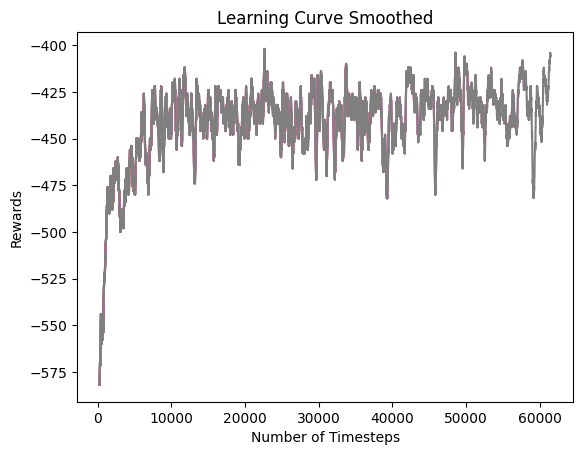

In [23]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 50, eval_freq= 25*128,
                            best_model_save_path=os.path.join(log_dir, "best_model_td3-50"),
                            callback_on_new_best=PlotResultsCallback(log_dir=log_dir))
# Eval callback, for plotting and seeing how the training is going, and saving best models. No effect on the results.

model.learn(total_timesteps=int(300000000000000000), callback=callback)


# Plot helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "TD3 - Env: Battery"
)


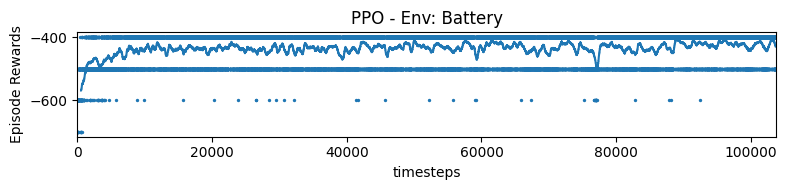

In [24]:
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

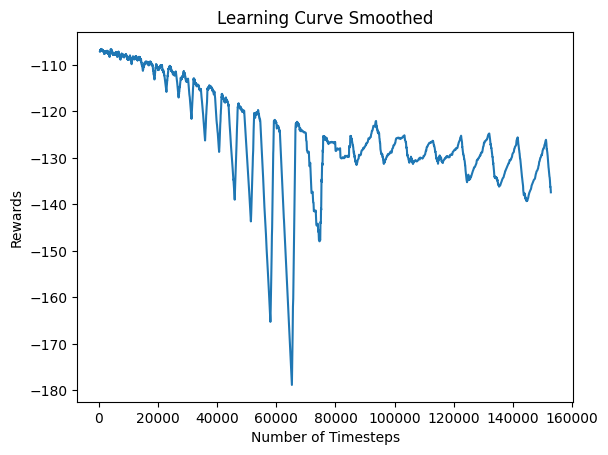

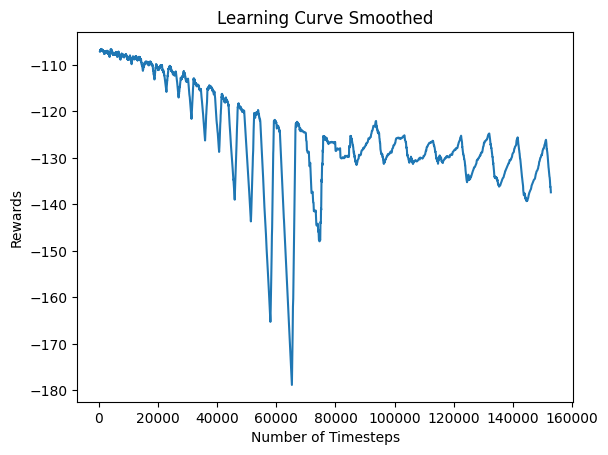

In [14]:

plot_results(log_dir)

# Test 1 episode of the model

[[0.5098291  0.58284587 0.7765862  0.5478103  0.8271166  0.6631476
  0.69134337 0.5128854  0.5560245  0.7531972  0.7284306  0.81732386
  0.58664584 0.5002466  0.74026257 0.8206702  0.69334567 0.6704196
  0.7880724  0.5852149  0.63918847 0.78562254 0.5719384  0.5880221
  0.5406691  0.5974264  0.6434034  0.7655735  0.6606481  0.8252079
  0.5866846  0.6451334  0.66074264 0.58009905 0.51613003 0.5672451
  0.6307708  0.7419163  0.7925226  0.615715   0.7525726  0.5491565
  0.68405086 0.5744509  0.8472798  0.5393819  0.5607359  0.5250477
  0.6995178  0.52395254]]  ACTION:[0.01342089 0.02603518 0.08657441 0.09708928 0.04537484 0.09874963
 0.09887232 0.09662823 0.07783596 0.09396163 0.03880022 0.09627209
 0.02952864 0.04399815 0.09231168 0.05899082 0.09649554 0.09833778
 0.0304519  0.09998535 0.09575468 0.03357963 0.09935325 0.09806815
 0.09496419 0.06544106 0.01373383 0.09593521 0.09551153 0.09963106
 0.08275387 0.09901033 0.0980475  0.0952018  0.05229754 0.09038252
 0.09212521 0.09848127 0.09

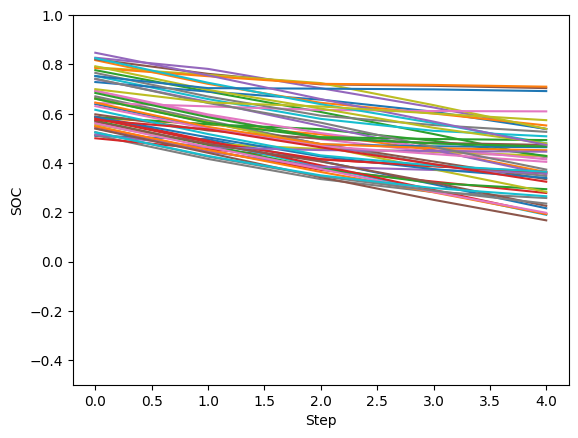

In [25]:

model.save(os.path.join(log_dir, "best_model_td3-n"))


def test_trained_model():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        oldObs = obs
        obs, rewards, done, info = model.get_env().step(action)
        episode_reward += rewards.squeeze()

        if not done:
            print(str(oldObs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>> ")
            print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([-0.5, 1])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            # plt.legend()
            #plt.pause(3)

            obsArray = []
            episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break




test_trained_model()
